In [18]:
import pandas as pd
df = pd.read_csv('t2g2_main.csv')
df.head()

,timestamp,temp,hum,air
0,2024-07-01 14:50:00,24.41,62.86,24.86
1,2024-07-01 15:00:00,24.11,63.60,24.02
2,2024-07-01 15:10:00,23.14,66.53,23.62
3,2024-07-01 15:20:00,23.06,67.16,24.00
4,2024-07-01 15:30:00,22.82,68.51,25.00


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px
fig = px.scatter_3d(df, x='temp', y='hum', z='air')
fig.show()

# KNN Clustering

In [20]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [21]:
# extract features
X = df[['temp', 'hum', 'air']]

# scale the parameters
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

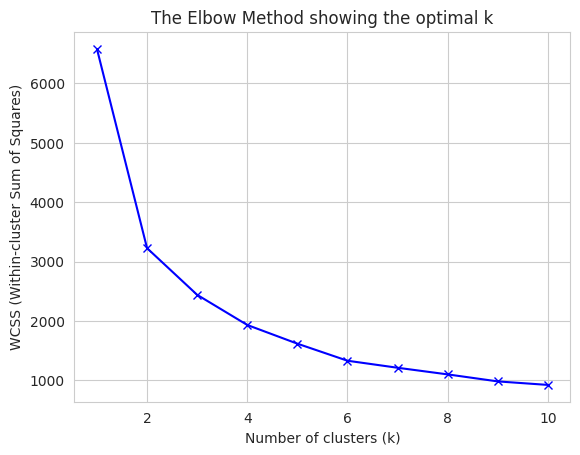

In [22]:
# Determine the optimal number of clusters using the Elbow method
wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# visualize errors
plt.plot(k_values, wcss, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.title('The Elbow Method showing the optimal k')
plt.show()

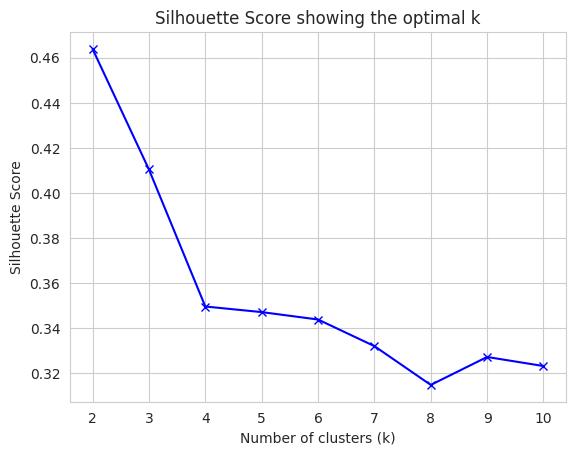

In [23]:
# Calculate silhouette scores for different values of k
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    if k > 1:  # Silhouette score is undefined for k=1
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(k_values[1:], silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score showing the optimal k')
plt.show()

In [26]:
# 2 clusters will give the highest Silhouette score, and the errors decreased noticeable at 2 clusters
# Train the final KMeans model
kmeans = KMeans(n_clusters=2, random_state=42, n_init='auto')
kmeans.fit(X_scaled)

# Predict the clusters for each data point
clusters = kmeans.predict(X_scaled)

# Add the cluster labels to the original DataFrame
df['Cluster'] = clusters

# Display the first few rows with cluster labels
df.head()

,timestamp,temp,hum,air,Cluster
0,2024-07-01 14:50:00,24.41,62.86,24.86,1
1,2024-07-01 15:00:00,24.11,63.60,24.02,1
2,2024-07-01 15:10:00,23.14,66.53,23.62,1
3,2024-07-01 15:20:00,23.06,67.16,24.00,1
4,2024-07-01 15:30:00,22.82,68.51,25.00,1


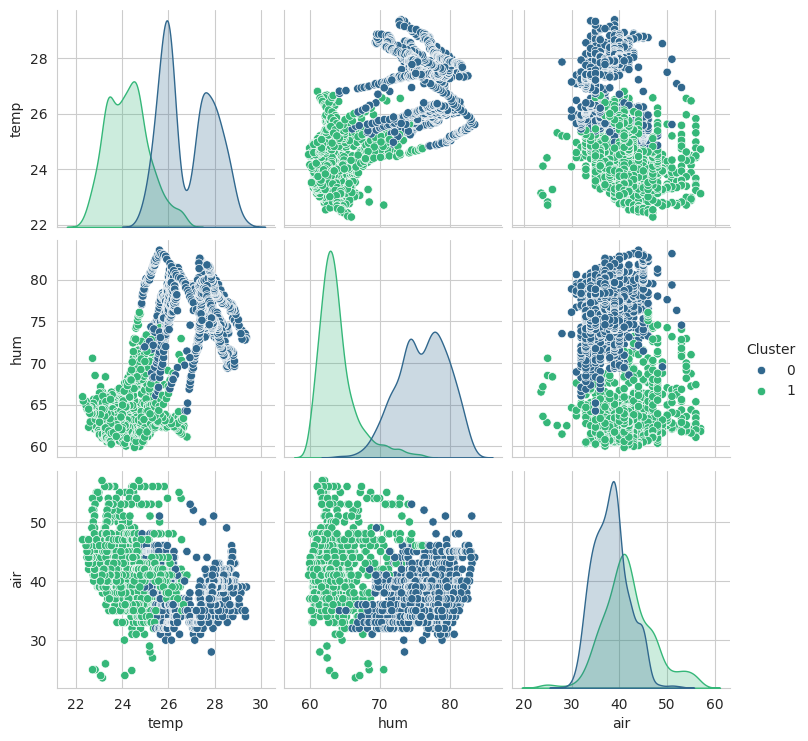

In [27]:
sns.pairplot(df, hue='Cluster', palette='viridis')
plt.savefig('clustered_pairplot.png')
plt.show()

In [28]:
fig = px.scatter_3d(df, x='temp', y='hum', z='air', color='Cluster')
fig.show()

In [29]:
# cluster 1 has temp lower than 25 and lower humidity compared to cluster 0
# which is good in offices and factories

def categorize_cluster(row):
    if row['Cluster'] == 0:
        return 'Hot & Humid'
    elif row['Cluster'] == 1:
        return 'Optimal'
    else:
        return 'Unknown'

df['knn_condition'] = df.apply(categorize_cluster, axis=1)
df.drop('Cluster', axis=1, inplace=True)
df.head()

,timestamp,temp,hum,air,knn_condition
0,2024-07-01 14:50:00,24.41,62.86,24.86,Optimal
1,2024-07-01 15:00:00,24.11,63.60,24.02,Optimal
2,2024-07-01 15:10:00,23.14,66.53,23.62,Optimal
3,2024-07-01 15:20:00,23.06,67.16,24.00,Optimal
4,2024-07-01 15:30:00,22.82,68.51,25.00,Optimal


In [30]:
df.knn_condition.value_counts()

,count
knn_condition,
Hot & Humid,1221
Optimal,973


In [31]:
df[df['knn_condition'] == 'Optimal'].head()

,timestamp,temp,hum,air,knn_condition
0,2024-07-01 14:50:00,24.41,62.86,24.86,Optimal
1,2024-07-01 15:00:00,24.11,63.60,24.02,Optimal
2,2024-07-01 15:10:00,23.14,66.53,23.62,Optimal
3,2024-07-01 15:20:00,23.06,67.16,24.00,Optimal
4,2024-07-01 15:30:00,22.82,68.51,25.00,Optimal


In [32]:
df[df['knn_condition'] == 'Hot & Humid'].head()

,timestamp,temp,hum,air,knn_condition
36,2024-07-01 20:50:00,25.21,68.75,34.0,Hot & Humid
37,2024-07-01 21:00:00,25.23,69.09,35.0,Hot & Humid
38,2024-07-01 21:10:00,25.24,69.21,35.0,Hot & Humid
39,2024-07-01 21:20:00,25.28,69.90,36.0,Hot & Humid
40,2024-07-01 21:30:00,25.35,70.41,36.0,Hot & Humid


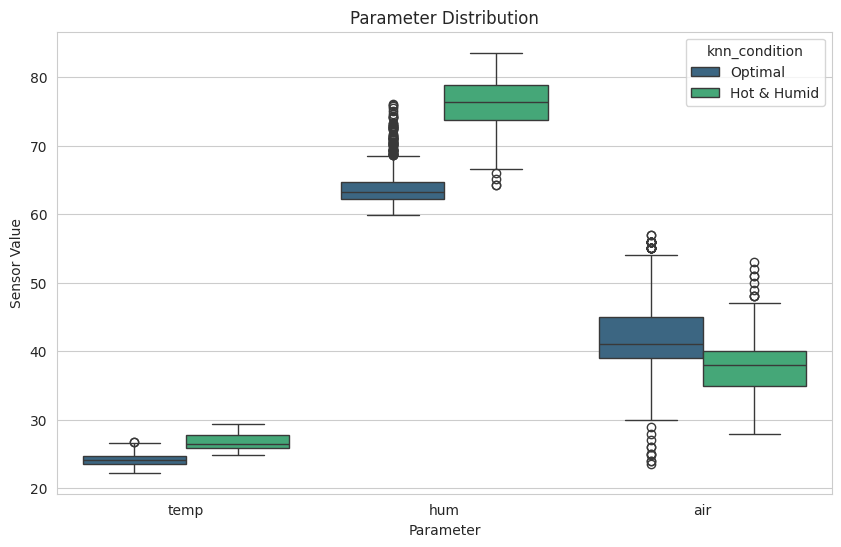

In [53]:
# Melt the DataFrame to convert it to long format
df_melted = df.set_index('timestamp').melt(id_vars='knn_condition', var_name='Parameter', value_name='Sensor Value')
# Convert 'Parameter' and 'knn_condition' columns to string type
df_melted['Parameter'] = df_melted['Parameter'].astype(str)
df_melted['knn_condition'] = df_melted['knn_condition'].astype(str)

# Now use the melted DataFrame to create the boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='Parameter', y='Sensor Value', hue='knn_condition', data=df_melted, palette='viridis')
plt.title('Parameter Distribution')
plt.xlabel('Parameter')
plt.ylabel('Sensor Value')
plt.show()

In [ ]:
# this shows why cluster 1 was taken as optimal and the other, cluster 0, as Hot & Humid

In [84]:
optimal = df[df['knn_condition'] == 'Optimal'].describe()
optimal.reset_index(inplace=True)
optimal.rename(columns={'index': 'Metric'}, inplace=True)
optimal

,Metric,temp,hum,air
0,count,973.000000,973.000000,973.000000
1,mean,24.235612,63.913741,41.775437
2,std,0.904219,2.709172,5.344974
3,min,22.280000,59.870000,23.620000
4,25%,23.490000,62.210000,39.000000
5,50%,24.190000,63.310000,41.000000
6,75%,24.790000,64.730000,45.000000
7,max,26.810000,76.090000,57.000000


In [85]:
optimal.to_csv('optimal.csv', index=False)
from google.colab import files
files.download('optimal.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Recurrent Neural Networks

In [54]:
!pip install keras tensorflow
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      2194 non-null   object 
 1   temp           2194 non-null   float64
 2   hum            2194 non-null   float64
 3   air            2194 non-null   float64
 4   knn_condition  2194 non-null   object 
dtypes: float64(3), object(2)
memory usage: 85.8+ KB


In [56]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.head()

,temp,hum,air,knn_condition
timestamp,,,,
2024-07-01 14:50:00,24.41,62.86,24.86,Optimal
2024-07-01 15:00:00,24.11,63.60,24.02,Optimal
2024-07-01 15:10:00,23.14,66.53,23.62,Optimal
2024-07-01 15:20:00,23.06,67.16,24.00,Optimal
2024-07-01 15:30:00,22.82,68.51,25.00,Optimal


In [57]:
# extract temp
temperature_data = df['temp'].values
temperature_data = temperature_data.reshape(-1, 1)

# scale
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(temperature_data)

In [59]:
# set the timestep for rnn
timesteps = 144 # 144 datapoints per day to get daily trends

X_train = []
y_train = []

for i in range(timesteps, len(scaled_data)):
    X_train.append(scaled_data[i-timesteps:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [62]:
from keras.models import Model
from keras.layers import Input, LSTM, Dropout, Dense

# Define the input layer
inputs = Input(shape=(X_train.shape[1], 1))

# Adding the first LSTM layer with Dropout regularization
x = LSTM(units=50, return_sequences=True)(inputs)
x = Dropout(0.2)(x)

# Adding the second LSTM layer with Dropout
x = LSTM(units=50, return_sequences=True)(x)
x = Dropout(0.2)(x)

# Adding the third LSTM layer with Dropout
x = LSTM(units=50, return_sequences=True)(x)
x = Dropout(0.2)(x)

# Adding the fourth LSTM layer with Dropout
x = LSTM(units=50)(x)
x = Dropout(0.2)(x)

# Adding the output layer
outputs = Dense(units=1)(x)

# Define the model using the Functional API
model = Model(inputs=inputs, outputs=outputs)

# Compile the RNN
model.compile(optimizer='adam', loss='mean_squared_error')

In [67]:
# train the model
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

model.fit(
    X_train,
    y_train,
    epochs=20, # for processing time sake without gpu
    batch_size=32,
    callbacks=[early_stopping]
) #9min to run

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - loss: 0.0023
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 327ms/step - loss: 0.0025
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - loss: 0.0028
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 314ms/step - loss: 0.0024
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - loss: 0.0022
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - loss: 0.0021
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 317ms/step - loss: 0.0019
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 312ms/step - loss: 0.0023
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 284ms/step - loss: 0.0018
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 319ms/step - loss: 0.0033
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 312ms/step - loss: 0.0020
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - loss: 0.0017
Epoch 13/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 289ms/step - loss: 0.0017
Epoch 14/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 314ms/step - loss: 0.0017
Epoch 15/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 

In [69]:
# Prepare test data with the same 144 timesteps
inputs = df['temp'][len(df) - len(X_train) - 144:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(144, len(inputs)):
    X_test.append(inputs[i-144:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predicting
predicted_temperature = model.predict(X_test)
predicted_temperature = scaler.inverse_transform(predicted_temperature)

65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step


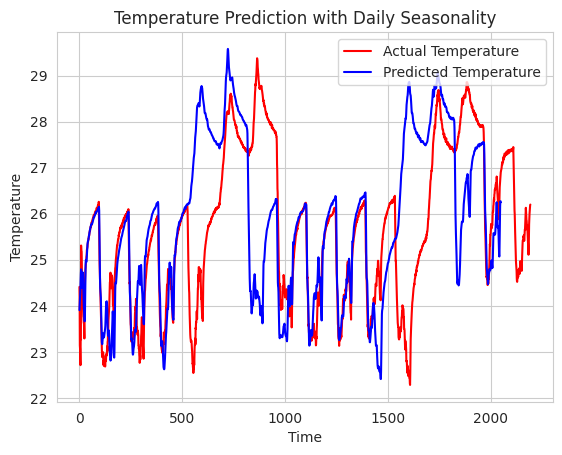

In [71]:
# visualize
plt.plot(df['temp'].values, color='red', label='Actual Temperature')
plt.plot(predicted_temperature, color='blue', label='Predicted Temperature')
plt.title('Temperature Prediction with Daily Seasonality')
plt.xlabel('Time (Index of Entry)')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [ ]:
# the accurate prediction of the temp by 1 day lag shows that the temp point are all normal and there is no anomality as the model can predict correctly and there is no big variations or errors between the predicted and actual temperature
# ac is working fine

In [77]:
# do the same for humidity
humidity_data = df['hum'].values
humidity_data = humidity_data.reshape(-1, 1)

# scale
# robust scaler is used as MinMaxScaler is sensitive to outliers and humidity has noticeable outliers
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = scaler.fit_transform(humidity_data)

# set the timestep for rnn
timesteps = 144 # 144 datapoints per day to get daily trends

X_train = []
y_train = []

for i in range(timesteps, len(scaled_data)):
    X_train.append(scaled_data[i-timesteps:i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Define the input layer
inputs = Input(shape=(X_train.shape[1], 1))

# Adding the first LSTM layer with Dropout regularization
x = LSTM(units=50, return_sequences=True)(inputs)
x = Dropout(0.2)(x)

# Adding the second LSTM layer with Dropout
x = LSTM(units=50, return_sequences=True)(x)
x = Dropout(0.2)(x)

# Adding the third LSTM layer with Dropout
x = LSTM(units=50, return_sequences=True)(x)
x = Dropout(0.2)(x)

# Adding the fourth LSTM layer with Dropout
x = LSTM(units=50)(x)
x = Dropout(0.2)(x)

# Adding the output layer
outputs = Dense(units=1)(x)

# Define the model using the Functional API
model = Model(inputs=inputs, outputs=outputs)

# Compile the RNN
model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
early_stopping = EarlyStopping(
    monitor='loss',
    patience=3,
    restore_best_weights=True
)

model.fit(
    X_train,
    y_train,
    epochs=20, # for processing time sake without gpu
    batch_size=32,
    callbacks=[early_stopping]
) #9min to run

Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 36s 410ms/step - loss: 0.1133
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 321ms/step - loss: 0.0273
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 318ms/step - loss: 0.0180
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 329ms/step - loss: 0.0139
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 314ms/step - loss: 0.0130
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 300ms/step - loss: 0.0117
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 290ms/step - loss: 0.0106
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 320ms/step - loss: 0.0126
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 315ms/step - loss: 0.0087
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - loss: 0.0112
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step - loss: 0.0093
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 316ms/step - loss: 0.0080
Epoch 13/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 284ms/step - loss: 0.0081
Epoch 14/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 20s 285ms/step - loss: 0.0071
Epoch 15/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 

65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step


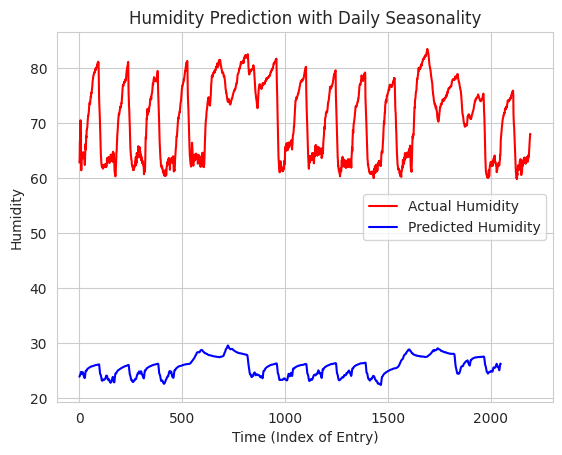

In [78]:
# the error is not being redcued much; it has reached to the end limit

# Prepare test data with the same 144 timesteps
inputs = df['hum'][len(df) - len(X_train) - 144:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(144, len(inputs)):
    X_test.append(inputs[i-144:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predicting
predicted_humidity = model.predict(X_test)
predicted_humidity = scaler.inverse_transform(predicted_humidity)

# visualize
plt.plot(df['hum'].values, color='red', label='Actual Humidity')
plt.plot(predicted_temperature, color='blue', label='Predicted Humidity')
plt.title('Humidity Prediction with Daily Seasonality')
plt.xlabel('Time (Index of Entry)')
plt.ylabel('Humidity')
plt.legend()
plt.show()

In [79]:
# the trends look okay, but
# there is a great difference between the predicted and acutal humidity values; the model cannot learn from the data
# it indicates that the humidity level is not maintained as expected and needs improvement